In [13]:
import statsapi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
players = pd.read_csv("mlb_players_2021.csv")
pitches = pd.read_csv("regseason.csv")

In [18]:
players.rename(columns={"id" : "batter","fullName" : "batter_fullName" , "birthCountry" : "batter_birthCountry"}, inplace=True)
players.head()

,batter,batter_fullName,birthDate,batter_birthCountry,height,weight,primaryPosition,batSide,pitchHand,debutDate,active
0,642758,Domingo Acevedo,1994-03-06,Dominican Republic,"6' 7""",240,P,R,R,2021-06-21,True
1,664119,Austin Allen,1994-01-16,USA,"6' 1""",219,C,L,R,2019-05-11,False
2,462101,Elvis Andrus,1988-08-26,Venezuela,"6' 0""",210,SS,R,R,2009-04-06,False
3,642456,Luis Barrera,1995-11-15,Dominican Republic,"6' 0""",195,OF,L,L,2021-05-19,True
4,605135,Chris Bassitt,1989-02-22,USA,"6' 5""",217,P,R,R,2014-08-30,True


In [19]:
pitches.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat
0,1,SL,2021-10-03,85.1,2.39,6.05,"Detmers, Reid",641487,672282,single,...,2,4,Standard,Standard,293.0,0.079,0.780,0_1,bLpL,breaking
1,2,FF,2021-10-03,93.8,2.31,6.03,"Detmers, Reid",641487,672282,NaN,...,1,4,Standard,Standard,150.0,0.000,-0.045,0_0,bLpL,fastball
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,...,1,4,Standard,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,...,1,4,Standard,Standard,146.0,0.000,0.047,1_2,bRpL,fastball
4,5,FF,2021-10-03,94.3,2.08,6.15,"Detmers, Reid",664238,672282,NaN,...,1,4,Standard,Standard,151.0,0.000,0.000,1_2,bRpL,fastball


In [20]:
# Merge pitches df with info about the batter
full_df = pd.merge(pitches, players[["batter","batter_fullName","batSide", "batter_birthCountry"]], on="batter")
full_df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry
0,1,SL,2021-10-03,85.1,2.39,6.05,"Detmers, Reid",641487,672282,single,...,Standard,293.0,0.079,0.780,0_1,bLpL,breaking,J.P. Crawford,L,USA
1,2,FF,2021-10-03,93.8,2.31,6.03,"Detmers, Reid",641487,672282,NaN,...,Standard,150.0,0.000,-0.045,0_0,bLpL,fastball,J.P. Crawford,L,USA
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,...,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking,Dylan Moore,R,USA
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,...,Standard,146.0,0.000,0.047,1_2,bRpL,fastball,Dylan Moore,R,USA
4,5,FF,2021-10-03,94.3,2.08,6.15,"Detmers, Reid",664238,672282,NaN,...,Standard,151.0,0.000,0.000,1_2,bRpL,fastball,Dylan Moore,R,USA


In [21]:
# Remove the pitches that were fouled, in play, or swung at
not_hit = ["called_strike", "ball"]
pitches_not_hit = full_df[full_df['description'].isin(not_hit)].copy()
len(pitches_not_hit)

390288

So we have 390,000 pitches to work with that were thrown but not swung at or hit

In [22]:
# Check that we only have balls and called strikes
pitches_not_hit['description'].unique()

array(['called_strike', 'ball'], dtype=object)

In [23]:
pitches_not_hit["strike_zone"] = pitches_not_hit["zone"] <= 9 # Determine if the pitch was actually in the zone

pitches_not_hit["called_correctly"] = (
    ((pitches_not_hit["zone"] <= 9) & (pitches_not_hit["type"] == "S")) | # Pitch is in the zone and is called a strike  
    ((pitches_not_hit["zone"] > 9) & (pitches_not_hit["type"] == "B"))    # Pitch is not in the zone and is called a ball
) 
pitches_not_hit["called_correctly"] = pitches_not_hit["called_correctly"].astype(int) # This will be are target variable -- whether the pitch was called "correctly"

In [24]:
# Check how many pitches we have that were "called correctly"
len(pitches_not_hit[pitches_not_hit["called_correctly"] == 1])

357779

In [25]:
# Check how many pitches we have that were not "called correctly"
len(pitches_not_hit[pitches_not_hit["called_correctly"] == 0])

32509

So there are aound 360,000 correctly called pitches at 32,000 which are not called correctly -- we might want to consider removing some of the correctly called pitches so that we have the same amount for each. But 64,000 data points should be enough for training our model. 

# Feature Visualization

Before training a model, lets visualize some features of the dataset with relation to our target variable "called correctly" to help identify features which may be prevalent to the outcomes of our model. Lets start with release speed, with the idea that faster pitches are harder to call as the umpire will have less to to analyze the pitch and make the call. 

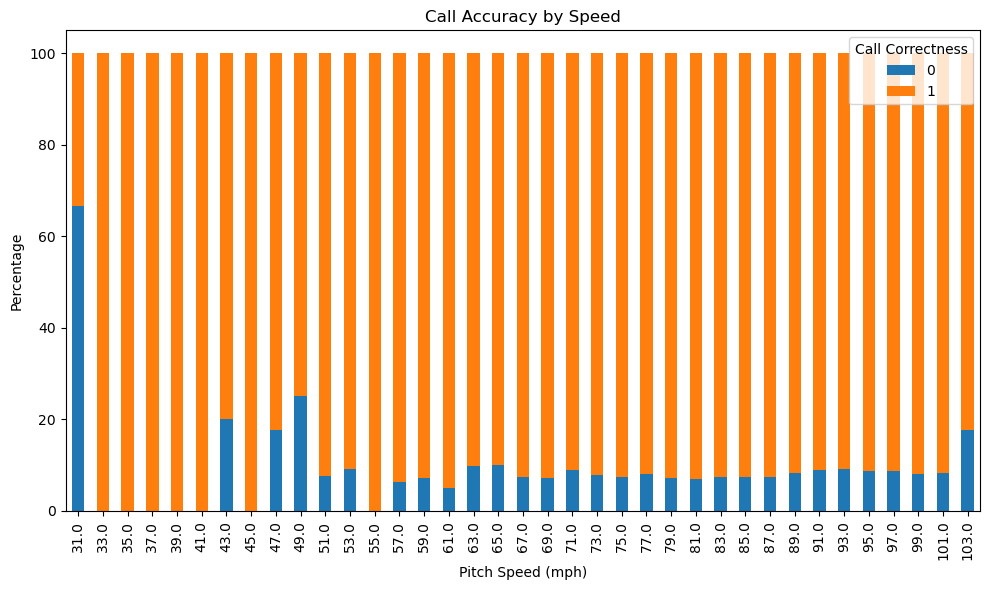

In [26]:
# create 2 mph speed groups
pitches_not_hit["speed_group"] = pitches_not_hit["release_speed"] // 2 

# Count pitches per speed_group and call correctness
grouped = pitches_not_hit.groupby(['speed_group', 'called_correctly']).size().unstack()

# Convert to percentage (so each bar sums to 100)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Recalculate midpoint speeds
grouped_percent.index = grouped_percent.index * 2 + 1  # 2 * group + 1 = midpoint

# Plot
grouped_percent.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.ylabel("Percentage")
plt.xlabel("Pitch Speed (mph)")
plt.title("Call Accuracy by Speed")
plt.legend(title = "Call Correctness", loc = "upper right")
plt.tight_layout()
plt.show()


Interestingly, it seems like pitch speed has little relationship to call accuracy. Lets now look at how release position affects call accuracy.

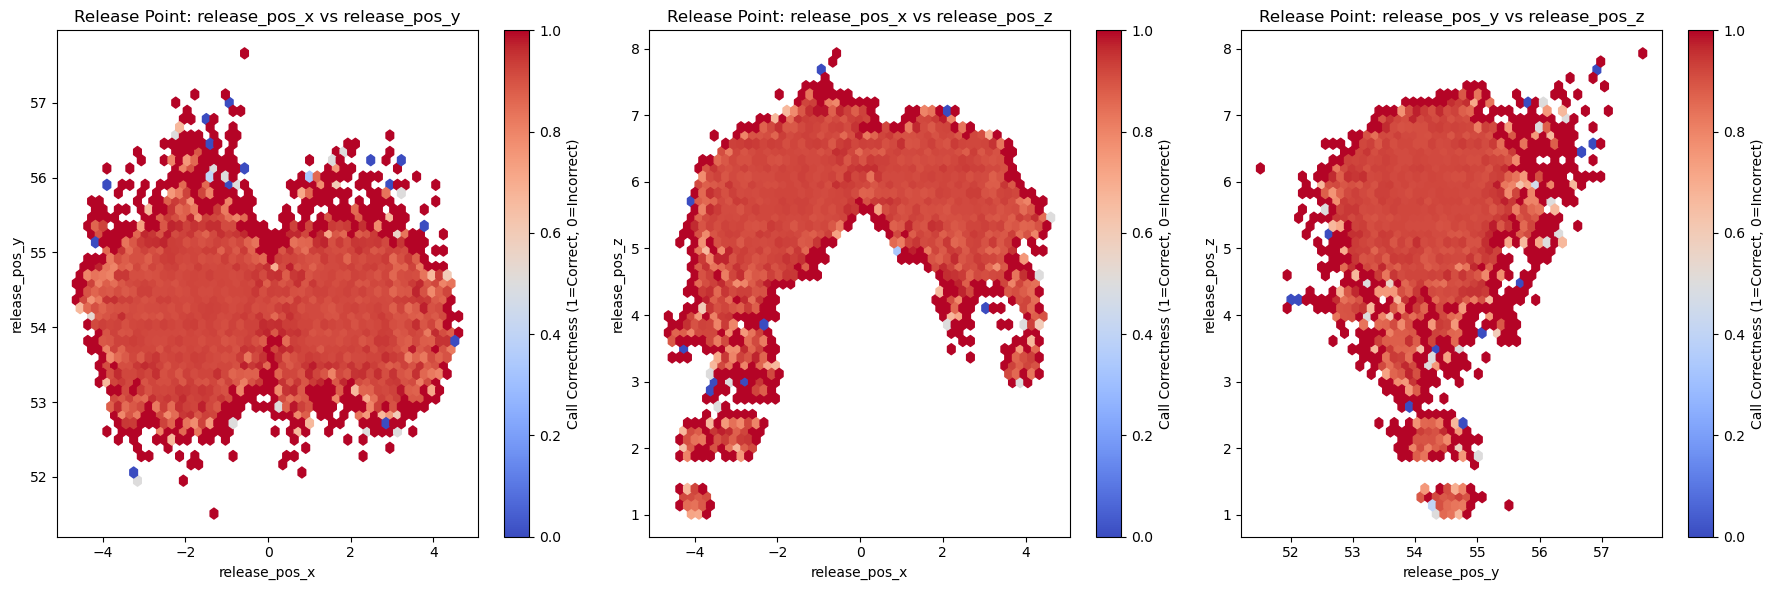

In [27]:
# create a density plot of release position in the x and y axis
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

# List of combinations for x, y, and z axes
combinations = [
    ('release_pos_x', 'release_pos_y'),
    ('release_pos_x', 'release_pos_z'),
    ('release_pos_y', 'release_pos_z')
]

# Loop over the combinations and plot hexbin on each subplot
for ax, (x_var, y_var) in zip(axes, combinations):
    hb = ax.hexbin(
        pitches_not_hit[x_var], 
        pitches_not_hit[y_var], 
        C = pitches_not_hit['called_correctly'],  # Color by correctness
        gridsize = 50, 
        cmap='coolwarm'
    )
    cb = fig.colorbar(hb, ax = ax, label = 'Call Correctness (1=Correct, 0=Incorrect)')
    ax.set_title(f"Release Point: {x_var} vs {y_var}")
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)

# Adjust layout
plt.tight_layout()
plt.show()

Generally, MLB umpires seem to be very good at calling pitches correctly. It doesn't seem like release position has a large impact on call correctness, although there may be marginally lower accuracy along the edges of the distributions. Lets see if spin rate has any affect, as pitches with more spin may be harder to predict. 

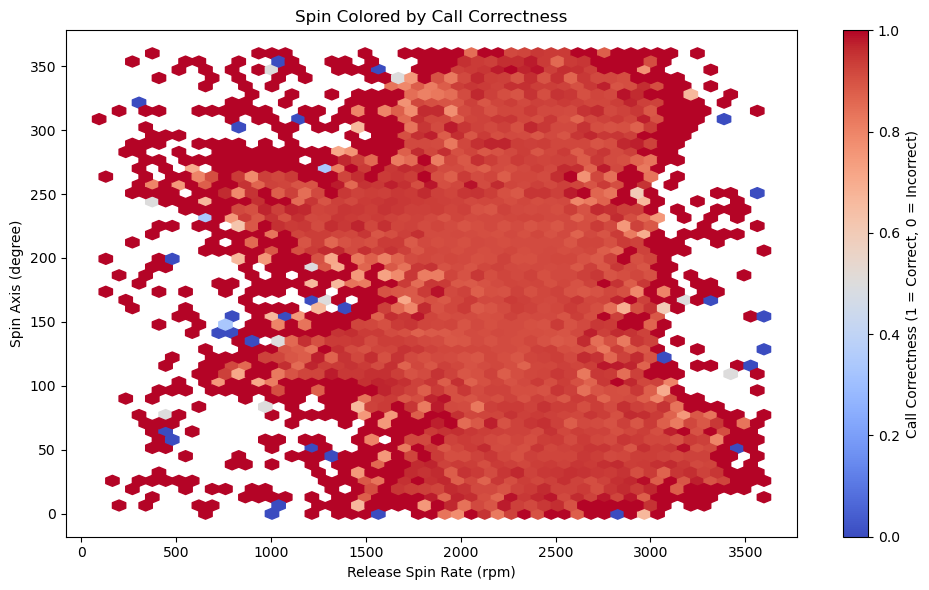

In [28]:
# create a density plot of release spin rate vs spin axis in the x and y axis

# Create the hexbin plot with color based on 'called_correctly'
plt.figure(figsize = (10, 6))
hb = plt.hexbin(
    pitches_not_hit['release_spin_rate'], 
    pitches_not_hit['spin_axis'], 
    C = pitches_not_hit['called_correctly'],  # Color by correctness
    gridsize = 50, 
    cmap = 'coolwarm'
)

# Add a colorbar
cb = plt.colorbar(hb, label='Call Correctness (1 = Correct, 0 = Incorrect)')

# Add labels and title
plt.title("Spin Colored by Call Correctness")
plt.xlabel("Release Spin Rate (rpm)")
plt.ylabel("Spin Axis (degree)")

plt.tight_layout()
plt.show()

Spin rate and spin axis seem to have even little effect on call correctness. Let's now look at categorical variables such as pitch_type, game_type,inning, and inning topbot.

# Generating a Model and Assessing its Bias

For this model we will subset our features to exclude where the actual pitch is when it crosses the plate, i.e. strike zone false/true and strike zone, and instead focus on features describing how the pitche was released and the gamestate when the pitch was thrown such pitch and inning count. First we will downsample and set up our training and testing split. 

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Creating a new variable to see if a game altering event (out or man on base) came as a result of the pitch
pitches_not_hit['has_event'] = pitches_not_hit['events'].notna().astype(int) 

y = pitches_not_hit["called_correctly"]
X = pitches_not_hit.drop(["called_correctly"], axis = 1)


# Combining into a new df
X_df = X.copy()
X_df['target'] = y

# Split into correct/incorrect
majority = X_df[X_df['target'] == 1]  # Correct calls
minority = X_df[X_df['target'] == 0]  # Incorrect calls

# Downsample majority
majority_downsampled = resample(
    majority,
    replace = False,# No replacement
    n_samples = len(minority),# Match number of minority examples
    random_state = 42
)

#Combine back
balanced = pd.concat([majority_downsampled, minority])
balanced = balanced.sample(frac = 1, random_state = 42).reset_index(drop = True)

# Set up x and y train balanced
X_balanced = balanced.drop(columns = ['target'])
y_balanced = balanced['target']

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced)

Select only the columns we want.

In [114]:
all_quant_cols_pi = [  # only numerical features that don't show where the pitch ends up
    'release_speed', 'release_pos_x', 'release_pos_z','balls', 'strikes',
    'outs_when_up', 'inning',
    'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate', 'release_extension',
    'release_pos_y', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score',
    'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score',
    'post_fld_score', 'spin_axis', 'delta_run_exp', 'delta_home_win_exp', 'has_event' #took out zone
]

all_qual_cols_pi = [ # only qualitiative features that don't show where the pitch ends up
    'pitch_type', 'game_date', 'events', 'description', 'des', 'game_type',
 'stand', 'p_throws', 'type', 'inning_topbot', 'pitch_name',
 'if_fielding_alignment', 'of_fielding_alignment', 'count', 'PBhand', 'pitch_cat', 
  'batSide',  #took out strike zone
]

Use a one-hot-encoder in the model to pre-process the data for all the qualitative columns.

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import random

random.seed(123)
qual_cols = all_qual_cols_pi
quant_cols = all_quant_cols_pi

#preprocessing for numeric and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', quant_cols),
        ('cat', Pipeline([
        ('encoder', OneHotEncoder(handle_unknown= 'ignore'))]), qual_cols) 
    ]
)

# Combine preprocessor with a logistic regression model
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))])

#Cleaning out rows with NaNs and re-fitting y to match
X_train_clean = X_train[quant_cols+ qual_cols].dropna() # so we don't have NA errors
y_train_clean = y_train.loc[X_train_clean.index]

X_test_clean = X_test[quant_cols + qual_cols].dropna()
y_test_clean = y_test.loc[X_test_clean.index]

# fit model on training set
clf.fit(X_train_clean, y_train_clean) 

# Evaluate on both training and test sets
train_score = accuracy_score(y_train_clean, clf.predict(X_train_clean))
test_score = accuracy_score(y_test_clean, clf.predict(X_test_clean))

print(f" Training Accuracy: {train_score:.4f}")
print(f" Test Accuracy: {test_score:.4f}")

 Training Accuracy: 0.6980
 Test Accuracy: 0.7145


c:\Users\miceo\anaconda3\envs\ml-0451\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


It seems that our model is able to predict whether or not the umpire makes the right a little better than call 2/3 of the time despite not knowing where the pitch ends up which implies there are factors other than the actual position the pitch crosses the plate which could be affecting umpire accuracy. Let's explore bias in the model by first looking at the accuracy for calling balls and strikes.

In [116]:
# start by separating data into balls and strikes
X_strikes = X_test[X_test["strike_zone"] == True]
X_balls = X_test[X_test["strike_zone"] == False]
y_strikes = y_test[X_test["strike_zone"] == True]
y_balls = y_test[X_test["strike_zone"] == False]

# apply our column transformation and drop na columns
X_strikes_clean = X_strikes[quant_cols + qual_cols].dropna()
X_balls_clean = X_balls[quant_cols + qual_cols].dropna()
y_strikes_clean = y_strikes.loc[X_strikes_clean.index]
y_balls_clean = y_balls.loc[X_balls_clean.index]

# pull accuracy scores for ptiches that were strikes and pitches that were balls
strikes_acc = accuracy_score(y_strikes_clean, clf.predict(X_strikes_clean))
balls_acc = accuracy_score(y_balls_clean, clf.predict(X_balls_clean))

# print the accuracy
print(f" Strikes Accuracy: {strikes_acc:.4f}")
print(f" Balls Accuracy: {balls_acc:.4f}")

 Strikes Accuracy: 0.0383
 Balls Accuracy: 0.9750


Interestingly, our model is exceptionally bad at predicting whether or not the umpire will make the correct call when the pitch is a strike, but is exceptionally good at predicting what the umpire when call when the pitch is a ball. Lets compare the model's predictive accuracy to the actual accuracy rates. And then generate an ROC curve for this data.

In [120]:
# pull the real accuracy rates from the data
strikes_real_acc = np.mean(pitches_not_hit["called_correctly"][pitches_not_hit["strike_zone"] == True])
balls_real_acc = np.mean(pitches_not_hit["called_correctly"][pitches_not_hit["strike_zone"] == False])

from tabulate import tabulate

# Create the data as a list of lists
table_data = [
    ["Call Type", "Model Accuracy", "Actual Accuracy"],
    ["Strike", f"{strikes_acc:.4f}", f"{strikes_real_acc:.4f}"],
    ["Ball", f"{balls_acc:.4f}", f"{balls_real_acc:.4f}"]
]

# Print the table
print(tabulate(table_data, headers = "firstrow", tablefmt = "grid"))

+-------------+------------------+-------------------+
| Call Type   |   Model Accuracy |   Actual Accuracy |
+=============+==================+===================+
| Strike      |           0.0383 |            0.8956 |
+-------------+------------------+-------------------+
| Ball        |           0.975  |            0.9264 |
+-------------+------------------+-------------------+


In the our actual data, Umpire's are more less likely to make the incorrect call on strikes than balls but the disrepancy is nowhere close to as large as the discrepancy in our model. Let's take generate an ROC curve and look at which features are being weighted the heaviest.

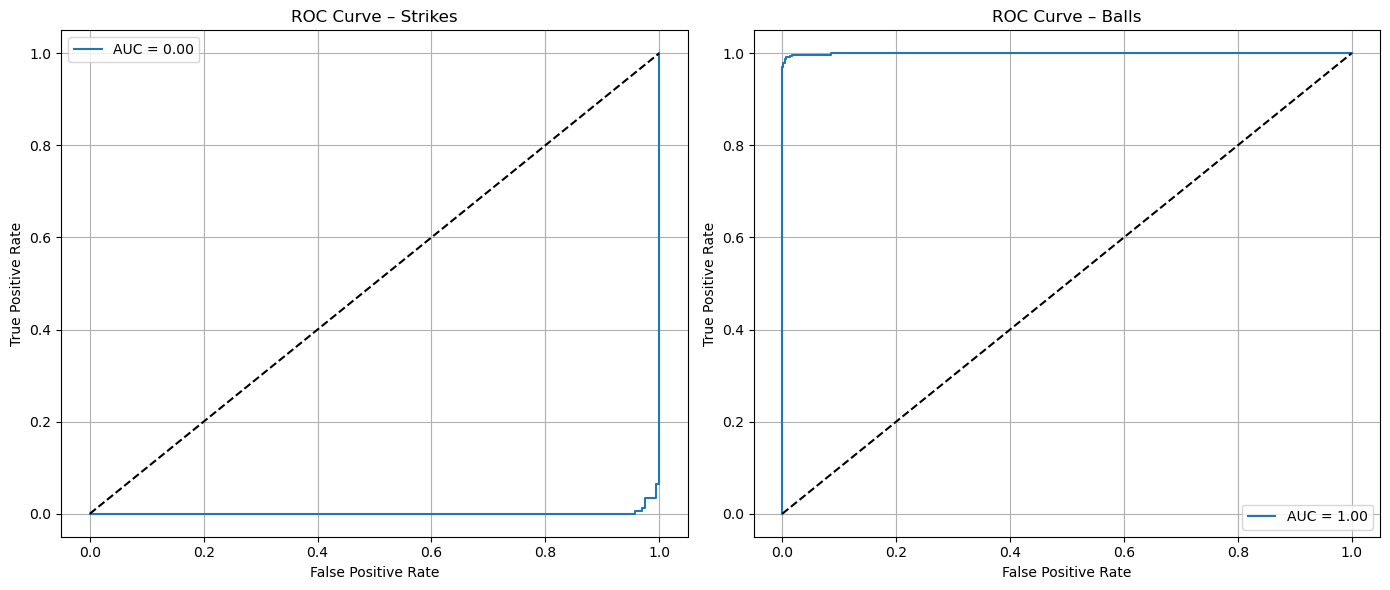

In [121]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (column index 1)
y_strikes_scores = clf.predict_proba(X_strikes_clean)[:, 1]
y_balls_scores = clf.predict_proba(X_balls_clean)[:, 1]

# Compute ROC curve values
fpr_strikes, tpr_strikes, _ = roc_curve(y_strikes_clean, y_strikes_scores)
roc_auc_strikes = auc(fpr_strikes, tpr_strikes)

fpr_balls, tpr_balls, _ = roc_curve(y_balls_clean, y_balls_scores)
roc_auc_balls = auc(fpr_balls, tpr_balls)

# Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize = (14, 6))

# Plot Strike ROC
axs[0].plot(fpr_strikes, tpr_strikes, label = f'AUC = {roc_auc_strikes:.2f}')
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_title('ROC Curve – Strikes')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend()
axs[0].grid()

# Plot Ball ROC
axs[1].plot(fpr_balls, tpr_balls, label = f'AUC = {roc_auc_balls:.2f}')
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_title('ROC Curve – Balls')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend()
axs[1].grid()

# Show both plots
plt.tight_layout()
plt.show()


C:\Users\miceo\AppData\Local\Temp\ipykernel_19480\2853885829.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Weight', y = 'Feature', data = coef_df_sorted, palette = 'coolwarm')


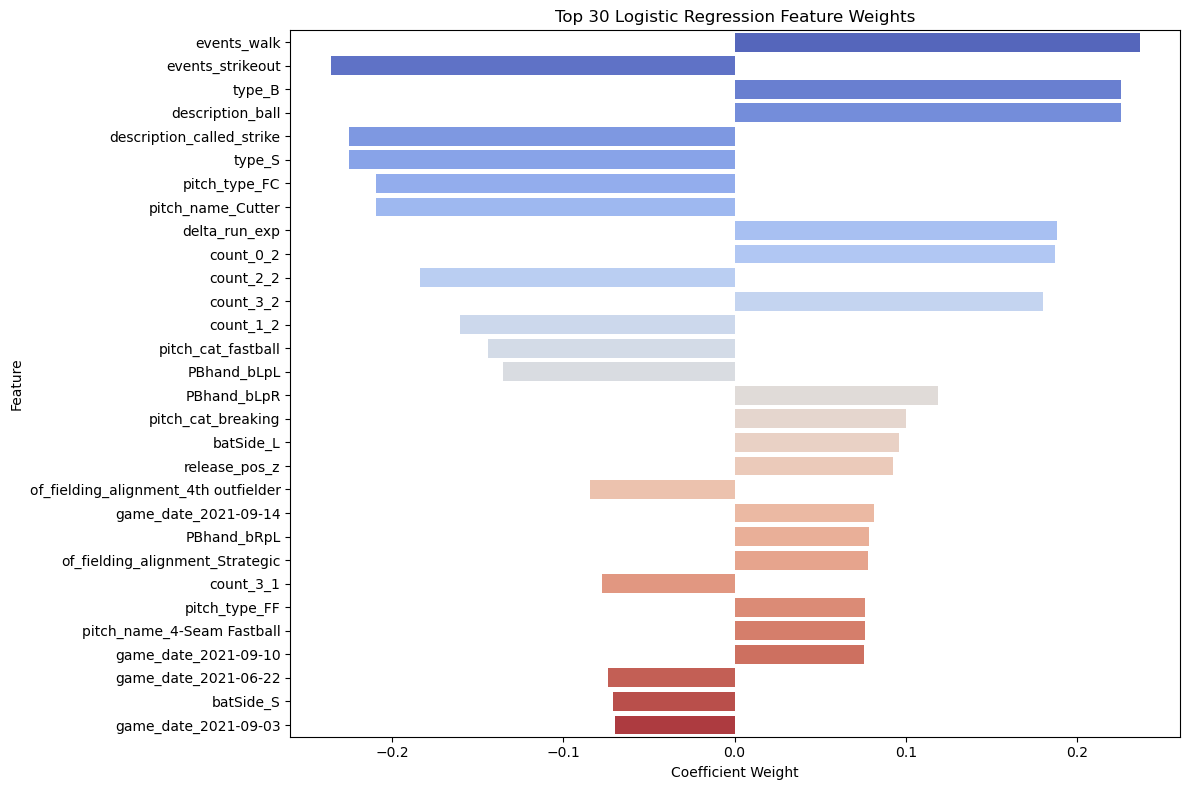

In [122]:
# Get the ecoded column names
ohe = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
ohe_feature_names = ohe.get_feature_names_out(qual_cols)

#combine numeric and encoded categorical feature names
feature_names = quant_cols + list(ohe_feature_names)

# Collect matching coefficents
coefficients = clf.named_steps['classifier'].coef_[0]

# Put coefficients into a DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': coefficients})

# Sort by absolute value weight
coef_df['abs_weight']= coef_df['Weight'].abs()
coef_df_sorted = coef_df.sort_values(by = 'abs_weight', ascending = False).head(30)  # top 30 most important

#Plot
plt.figure(figsize = (12, 8))
sns.barplot(x = 'Weight', y = 'Feature', data = coef_df_sorted, palette = 'coolwarm')
plt.title('Top 30 Logistic Regression Feature Weights')
plt.xlabel('Coefficient Weight')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()